In [2]:
import servo
import analyse
import plot

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pprint import pprint

from scipy.optimize import curve_fit
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches

In [6]:
def timestamps_to_displacement(timestamped_data, velocity):

    data = (timestamped_data
            .pipe(servo.reindex_timestamps_with_times)
            .pipe(servo.calculate_displacement, velocity)
           )
    displacement_data = data.set_index("Displacement (m)")

    
    return displacement_data
    

def plot_knife_edge_method(ax, dataset):
    xs = dataset.index.values*1E3 # in mm
    ys = dataset["Power (W)"].values*1E6 # in uW
    
    coeffs, coeff_errs = analyse.fit_erf(xs, ys)
    fit_ys = analyse.erf(xs, *coeffs)

    gauss_ys = analyse.G(xs, 2*coeffs[0], coeffs[1], coeffs[2]/np.sqrt(2))

    lower_bound, upper_bound = analyse.get_e_squared_range(xs, gauss_ys)

    ax.set_xlabel("Displacement [mm]")
    
    ax.plot(xs, ys, marker='.', linestyle='', color="tab:blue", label="meas")
    ax.plot(xs, fit_ys,linestyle='--', linewidth=3, color="tab:red", label="erf fit")
    ax.plot(xs, gauss_ys, linestyle='--', linewidth=3, color="tab:purple", label="gauss fit")
    
    plot.draw_dimension_lines(ax, upper_bound, lower_bound)
    ax.vlines(lower_bound, 0, max(ys), linestyle=':', linewidth=2, color="black")
    ax.vlines(upper_bound, 0, max(ys), linestyle=':',  linewidth=2, color="black")

    return upper_bound - lower_bound

def plot_result(files, velocity):
    timestamped_knife_measurements = map(servo.get_data, files)
    displacement_data = map(
        lambda m: timestamps_to_displacement(m, velocity),
        timestamped_knife_measurements
    )
    fig, axes = plt.subplots(len(files),1, dpi=250, sharex=True)
    axes = [axes]
    axes[0].set_ylabel("Power (uW)")
    diameters = np.array([
        plot_knife_edge_method(ax, data) for ax, data in zip(axes, [*displacement_data])
    ])
    mean_diam = diameters.mean()
    mean_diam_err = diameters.std()/np.sqrt(len(diameters))
    fig.suptitle(f"Mean Beam Radius: {round(1E3 * mean_diam/2, 0)} +/- {round(1E3 * mean_diam_err/2, 0)}um")
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', ncols=3, bbox_to_anchor=(0.1, 0.85, 0.8, 0.1))
    #plt.tight_layout()
    return mean_diam, mean_diam_err




23.68515
1.694012007314389


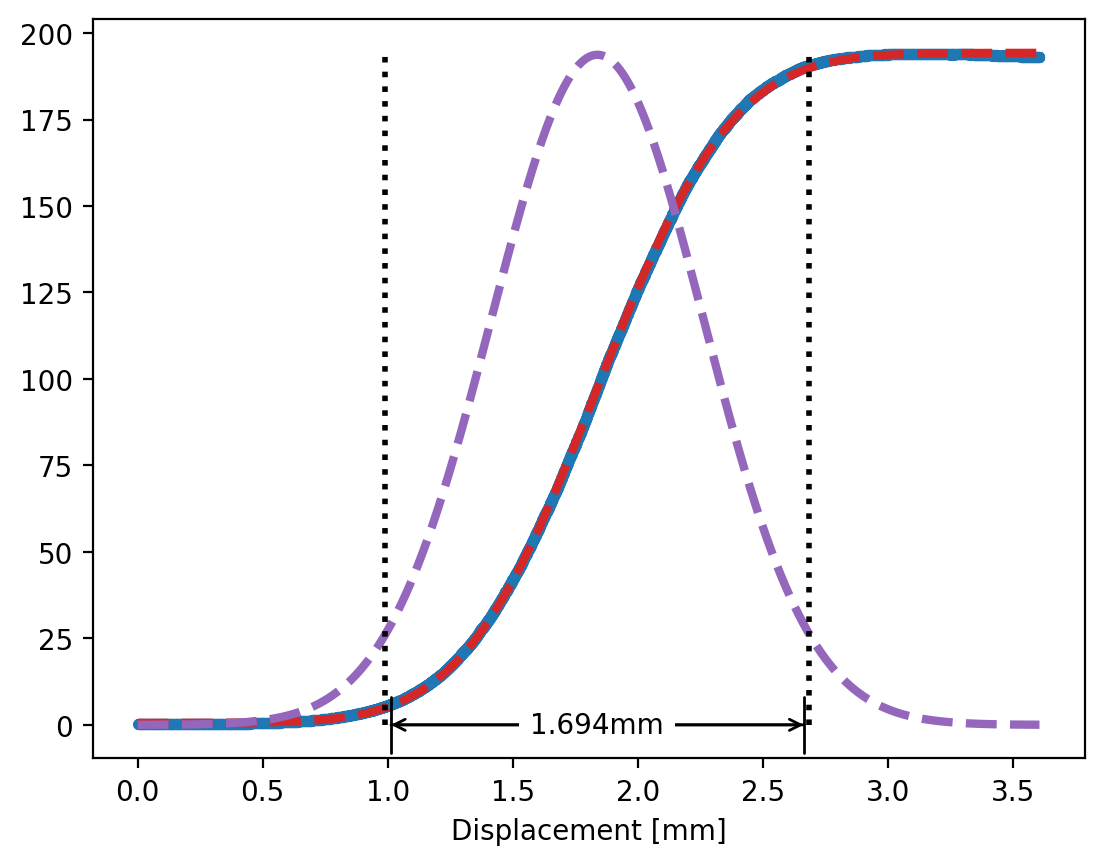

In [12]:
slow_v_d = pd.read_csv("Data/speed_1_data.txt", delimiter=",", header=1, usecols=[0,1])
velocity = analyse.get_average_velocity(slow_v_d)
file = "./Data/775/b.csv"

timestamped_knife_measurements = servo.get_data(file)
displacement_data = timestamps_to_displacement(timestamped_knife_measurements, velocity)
fig, ax = plt.subplots(dpi=200)
diams = plot_knife_edge_method(ax, displacement_data)
print(diams)